In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os
import glob
from h5_util import concatenate_files, load_h5
from scipy.optimize import curve_fit
import seaborn as sns

def violin_plot(to_plot, title=None, xlabel=None, ylabel=None, labels=None, savefig=None):
    
    fig = plt.figure()

    # Create an axes instance
    ax = fig.add_axes([0,0,1,1])

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if labels is not None:
        set_axis_style(ax, labels)

    # Create the boxplot
    bp = ax.violinplot(to_plot, showmedians=True, showmeans=True)
    bp['cmedians'].set_color('white')
    bp['cmeans'].set_color('black')
    for pc in bp['bodies']:
        #pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)
    if savefig is not None:
        fig.savefig(savefig, format='pdf', bbox_inches="tight")
    plt.show()
    
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

def group(key, metric, discard=None, action='append'):
    res = dict()
    for k,v in zip(key, metric):
        if discard is not None and discard(v):
            continue
        if action=='sum':
            res[k] = res.get(k, 0) + v
        elif action=='unique':
            if k not in res:
                res[k] = v
        else:
            if k not in res:
                res[k] = []
            res[k].append(v)
    return res
 
def box_plot(x, y, title=None, xlabel=None, ylabel=None, cmin=np.inf, save_path=None):
    uni, counts = np.unique(x, return_counts=True)
    asort = np.argsort(counts)
    i = next(i for i,x in enumerate(asort[-1::-1]) if counts[x]<cmin)
    uni = sorted(uni[asort[-i:]])
    to_plot = [y[x==u] for u in uni]
    print(f"Data has sizes {[len(x) for x in to_plot]}")
    plt.boxplot(to_plot, patch_artist=True, showfliers=False)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    if save_path is not None:
        plt.savefig(save_path, format='pdf')
    plt.show()    
    
def plot_means(x, y, title=None, xlabel=None, ylabel=None, cmin=np.inf, save_path=None):
    uni, counts = np.unique(x, return_counts=True)
    asort = np.argsort(counts)
    i = next(i for i,x in enumerate(asort[-1::-1]) if counts[x]<cmin)
    uni = sorted(uni[asort[-i:]])
    to_plot = []
    for u in uni:
        qf = y[x==u]
        to_plot.append(np.mean(qf))
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    plt.plot(uni, to_plot)
    if save_path is not None:
        plt.savefig(save_path, format='pdf')
    plt.show()
    
    
src_dir = 'data/gastric_104_tum_1'

In [2]:
data = load_h5(os.path.join(src_dir, "info.h5"))

In [3]:
for key,value in data.items():
    print(key)
    for k,v in value.items():
        print(k,v.shape)

global
alleles (217951,)
alleles_kept (217951,)
chrom (217951,)
motif_len (217951,)
n_reads (217951,)
n_reads_corr (217951,)
n_umi (217951,)
n_umi_corr (217951,)
nucl (217951,)
start (217951,)
stop (217951,)
umi
alleles (250496,)
avg_qual (250496,)
cfreq (250496,)
chrom (250496,)
count (250496,)
freq (250496,)
motif_len (250496,)
nucl (250496,)
qual (250496,)
start (250496,)
stop (250496,)


In [4]:
np.unique(data['global']['alleles_kept'], return_counts=True)

(array([1, 2, 3, 4, 5, 6]),
 array([187751,  28365,   1684,    144,      6,      1]))

### At umi level

In [5]:
data_umi = data['umi']

#### Frequency of selected indel

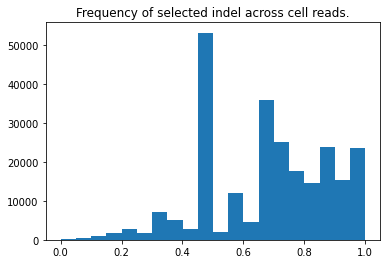

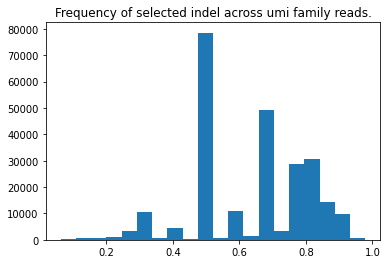

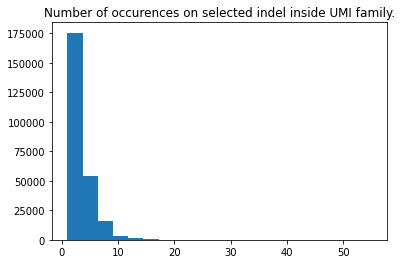

In [6]:
plt.hist(data_umi['cfreq'], bins=20)
plt.title('Frequency of selected indel across cell reads.')
plt.show()
plt.hist(data_umi['freq'], bins=20)
plt.title('Frequency of selected indel across umi family reads.')
plt.show()
plt.hist(data_umi['count'], bins=20)
plt.title('Number of occurences on selected indel inside UMI family.')
plt.show()

#### Selected indel base quality vs frequency

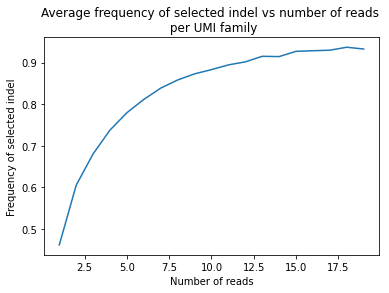

In [13]:
plot_means(
    data_umi['count'], 
    data_umi['freq'], 
    xlabel='Number of reads',
    ylabel = 'Frequency of selected indel',
    title = 'Average frequency of selected indel vs number of reads \n per UMI family',
    cmin = 20,
    #save_path = 'plots/count-freq.pdf'
)

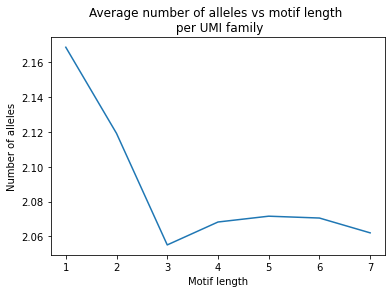

In [22]:
plot_means(
    data_umi['motif_len'], 
    data_umi['alleles'], 
    xlabel='Motif length',
    ylabel = 'Number of alleles',
    title = 'Average number of alleles vs motif length \n per UMI family',
    save_path = 'plots/mlen-alleles.pdf'
    #cmin = 20
)

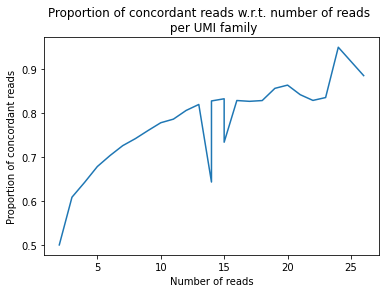

In [102]:
plot_means(
    np.divide(data_umi['count'],data_umi['freq']),
    data_umi['freq'], 
    cmin=3,
    xlabel='Number of reads',
    ylabel='Proportion of concordant reads',
    save_path='nreads-pdisc.pdf',
    title='Proportion of concordant reads w.r.t. number of reads \n per UMI family'
)

### At (site, cell) level

In [8]:
data_global = data['global']

#### Proportion of corrected reads wtr to STR length

Data has sizes [173267, 11527, 9511, 8284]


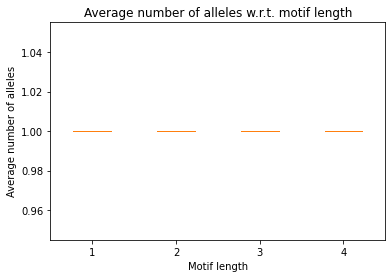

In [65]:
def fun(x, a, b, c):
    return a+b*np.exp(c*x)

start = data['global']['start']
stop = data['global']['stop']

n_corr = group(start, data_global['n_reads_corr'], action='sum')
n_reads = group(start, data_global['n_reads'], action='sum')
props = {k: n_corr[k]/n_reads[k] for k in n_corr.keys()}
n_al = group(stop-start, data_global['alleles_kept'], action='append')
n_al = {k: np.mean(v) for k,v in n_al.items()}
str_lens = group(start, stop-start, action='unique')
motif_lens = group(start, data_global['motif_len'], action='unique')

X = np.unique(stop-start)
X_ = X[X<50]


Y_ = [n_al[k] for k in X_]
plt.plot(X_, Y_)
#p_opt, _ = curve_fit(fun,  X_,  Y_)
#plt.plot(X_, fun(X_, *p_opt), color='red')
plt.xlabel('STR length')
plt.ylabel('Average nb of alleles after correction')
plt.title('Average number of alleles after correction \n w.r.t. STR length')
plt.savefig('strlen-nkept.pdf', format='pdf')
plt.show()

Y = np.array([props[k] for k in str_lens])
M = np.array([motif_lens[k] for k in str_lens])
S = np.array(list(str_lens.values()))

for i in range(1,5):
    keep = M==i
    X_i = np.unique(S[keep])
    Y_i = group(S[keep], Y[keep], action='append')
    keep2 = np.array([len(v)>3 for v in Y_i.values()])
    Y_i = np.array([np.mean(v) for v in Y_i.values()])
    Y_i = np.convolve(Y_i, np.ones(3)/3)[2:]
    plt.plot(X_i[keep2], Y_i[keep2], label=str(i))
plt.legend()
plt.title('Average proportion of discordant reads w.r.t. STR length \n for motif lengths 1-4')
plt.xlabel('STR length')
plt.ylabel('Proportion of discordant reads')
plt.savefig('strlen-ndisc-mlen.pdf', format='pdf')
plt.show()
"""

X = data_global['motif_len']
Y = data_global['alleles_kept']
#Y = np.divide(data_global['n_reads_corr'],data_global['n_reads'])
box_plot(
    X[X<5],
    Y[X<5], 
    title='Average number of alleles w.r.t. motif length',
    #save_path = 'plots/mlen-ncorr.pdf',
    xlabel = 'Motif length',
    ylabel = 'Average number of alleles'
)
"""

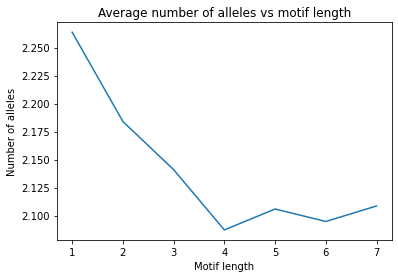

In [16]:
plot_means(
    data_global['motif_len'], 
    data_global['alleles'], 
    xlabel='Motif length',
    ylabel = 'Number of alleles',
    title = 'Average number of alleles vs motif length',
    save_path = 'plots/mlen-alleles.pdf'
    #cmin = 20
)

In [54]:
nal_dict = {
    k:v for k,v in zip(*np.unique(
        data_global['stop']-data_global['start'], return_counts=True
    ))
}

#### Proportion of bi-allelic sites after correction

(array([2, 3, 4, 5, 6, 7, 8]), array([177346,  31960,   6920,   1349,    291,     68,     17]))


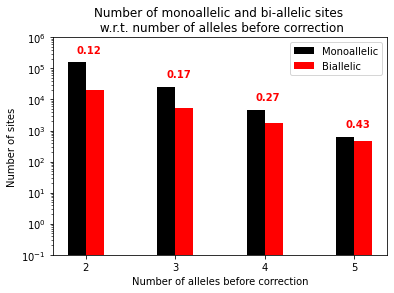

In [39]:
n, m =  (4,2)
print(np.unique(data_global['alleles'], return_counts=True))
n_al = np.zeros((n,m))
n_intrus = 0
for x,y in zip(data_global['alleles'], data_global['alleles_kept']):
    if y>2 or x>5:
        n_intrus += 1
        continue
    n_al[x-2][y-1]+=1

w = 0.4
dimw = w / 2

fig, ax = plt.subplots()
x = np.arange(n)+2
ax.bar(x-0.1, n_al[:,0], dimw, label='Monoallelic', color='black', bottom=0.1)
ax.bar(x+0.1, n_al[:,1], dimw, label='Biallelic', color='red', bottom=0.1)

for i, v in enumerate(n_al):
    ax.text(x[i]-0.1, 2*max(v[1],v[0]), str(np.round(v[1]/(v[0]+v[1]), 2)), color='red', fontweight='bold')

ax.set_xticks(x)
ax.set_ylim(0.1,10**6)
ax.set_yscale('log')

ax.set_xlabel('Number of alleles before correction')
ax.set_ylabel('Number of sites')
ax.set_title('Number of monoallelic and bi-allelic sites \n w.r.t. number of alleles before correction')
ax.legend()
fig.savefig('plots/bef-aft.pdf', format='pdf')
fig.show()

#### Proportion of discordant reads per motif type at site level

Data has sizes [12684, 403, 377, 12506]


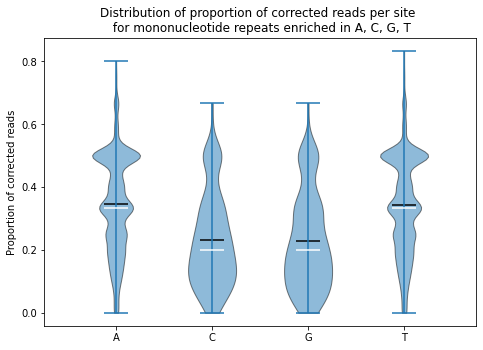

"\nfor l in uni:\n    pl = props_arr[motif_len_arr==l]\n    #pf = np.clip(pf, 0, 1)\n    to_plot.append(pl)\n\nviolin_plot(\n    to_plot,\n    labels=tuple(uni),\n    title='Distribution of proportion of corrected reads per site \n for motif lengths 2-7',\n)\nplt.show()\n\n\nmlen = 1\nto_plot = []\nn_reads = np.array(list(n_reads.values()))\nfor c in acgt:\n    keep = np.multiply(nucls_arr==c, mlen_arr==mlen)\n    props_c = group(nreads_arr[keep], props_arr[keep], action='append')\n    props_c = [np.mean(v) for v in props_c.values()]\n    plt.plot(plots_c, label=str(c))\nplt.show()\n"

In [104]:
to_discard = lambda x: x-0.001-int(x)<0.4
pos = data['global']['start']

n_corr = group(pos, data_global['n_reads_corr'], action='sum')
n_reads = group(pos, data_global['n_reads'], action='sum')
n_kept = group(pos, data_global['alleles_kept'], action='append')
nucls = group(pos, data_global['nucl'], discard=to_discard, action='unique')
motif_lens = group(pos, data_global['motif_len'], action='unique')

props_arr = np.array([n_corr[k]/n_reads[k] for k in nucls])
mlen_arr = np.array([motif_lens[k] for k in nucls])
nucls_arr = np.array([chr(int(nucls[k]-0.001)) for k in nucls])
nreads_arr = np.array([[k] for k in nucls])


acgt = ['A', 'C', 'G', 'T']
for mlen in [1]:
    to_plot = []
    for c in acgt:
        pc = props_arr[np.multiply(nucls_arr==c, mlen_arr==mlen)]
        #pc = np.clip(pc, 0, 1)
        to_plot.append(pc)
    rtype = 'mononucleotide' if mlen==1 else 'binucleotide'
    print(f'Data has sizes {[len(v) for v in to_plot]}')
    violin_plot(
        to_plot,
        labels=tuple(acgt),
        title=f'Distribution of proportion of corrected reads per site \n for {rtype} repeats enriched in A, C, G, T',
        savefig='plots/nucl-ncorr-mono.pdf',
        ylabel = 'Proportion of corrected reads'
    )
    plt.show()

uni = np.unique(mlen_arr)

"""
for l in uni:
    pl = props_arr[motif_len_arr==l]
    #pf = np.clip(pf, 0, 1)
    to_plot.append(pl)

violin_plot(
    to_plot,
    labels=tuple(uni),
    title='Distribution of proportion of corrected reads per site \n for motif lengths 2-7',
)
plt.show()


mlen = 1
to_plot = []
n_reads = np.array(list(n_reads.values()))
for c in acgt:
    keep = np.multiply(nucls_arr==c, mlen_arr==mlen)
    props_c = group(nreads_arr[keep], props_arr[keep], action='append')
    props_c = [np.mean(v) for v in props_c.values()]
    plt.plot(plots_c, label=str(c))
plt.show()
"""

#### Proportion of corrected reads & umis

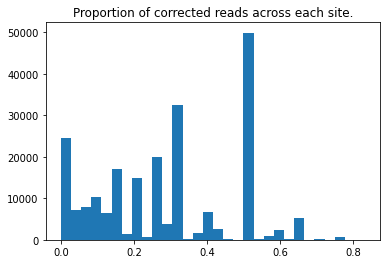

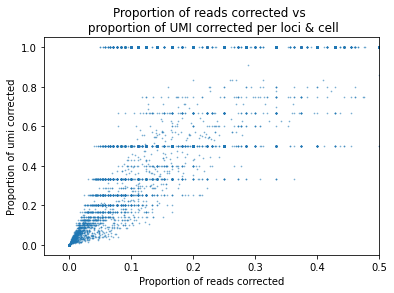

In [28]:
X = np.divide(data['global']['n_reads_corr'], data['global']['n_reads'])
Y = np.divide(data['global']['n_umi_corr'], data['global']['n_umi'])
plt.hist(X, bins=30)
plt.title('Proportion of corrected reads across each site.')
plt.show()
plt.scatter(X[:20000], Y[:20000], alpha=0.5, s=0.5)
plt.title('Proportion of reads corrected vs \n proportion of UMI corrected per loci & cell')
a,b = plt.xlim()
plt.xlim(a,0.5)
plt.xlabel('Proportion of reads corrected')
plt.ylabel('Proportion of umi corrected')
plt.savefig('plots/readcorr-umicorr.pdf', format='pdf')
plt.show()

In [20]:
for k,v in data['umi'].items():
    u,c = np.unique(v, return_counts=True)
    if len(u)<30:
        print(k)
        print(list(zip(u,c)))

alleles
[(2, 38091), (3, 2399), (4, 166), (5, 13)]
chrom
[(1, 4903), (2, 2303), (3, 3313), (4, 1136), (5, 1503), (6, 2018), (7, 1880), (8, 1090), (9, 1381), (10, 1220), (11, 2995), (12, 2043), (13, 591), (14, 1489), (15, 1103), (16, 1653), (17, 3333), (18, 633), (19, 2238), (20, 893), (21, 327), (22, 966), (88, 1646), (89, 12)]
count
[(1, 14036), (2, 10825), (3, 6686), (4, 3979), (5, 2254), (6, 1301), (7, 764), (8, 379), (9, 202), (10, 96), (11, 49), (12, 24), (13, 28), (14, 13), (15, 12), (16, 7), (17, 4), (18, 5), (19, 2), (20, 1), (21, 1), (26, 1)]
motif_len
[(2, 9140), (3, 11306), (4, 6025), (5, 6068), (6, 5047), (7, 3083)]
qual
[(0.0, 40669)]


In [ ]:
n_al = group(pos, data_global['alleles'], action='append')
Y = [np.mean(n_al[k]) for k in lengths]
Y = group(lengths.values(), Y, action='append')
Y = np.array([np.mean(Y[k]) for k in X])
plt.plot(X[X<50], Y[X<50])
plt.title('Average number of alleles w.r.t. STR length')
plt.xlabel('STR length')
plt.ylabel('Average number of alleles')
plt.show()
